In [1]:
import numpy as np

In [2]:
import os

In [3]:
from updown_data import updown_z

In [4]:
from export_train_test import export_train_validation_test

for i in range(100):
    updown_z(i, "aafiles/Jpp_v6_aa_files/Xy_files/Xy_numu_"+str(i+1)+"_sel5_doms.npz", 
             "aafiles/Jpp_v6_aa_files/Xy_files/numu_"+str(i+1)+"_sel5_dir_z.npz",
            "Xy_files/updown/", "Xy_numu")

for i in range(100):
    updown_z(i, "aafiles/Jpp_v6_aa_files/Xy_files/Xy_nue_"+str(i+1)+"_sel5_doms.npz", 
             "aafiles/Jpp_v6_aa_files/Xy_files/nue_"+str(i+1)+"_sel5_dir_z.npz",
            "Xy_files/updown/", "Xy_nue")

folder = os.path.join("Xy_files", "updown")
for i in range(100):
    export_train_validation_test(i, os.path.join(folder,"Xy_numu{}_sel5_doms_updown_z.npz".format(i+1)),
                            os.path.join(folder,"Xy_nue{}_sel5_doms_updown_z.npz".format(i+1)),
                            out_dir = os.path.join("train_test_files","updown_z"))
    print("file {} completed".format(i+1))

In [4]:
import matplotlib.pyplot as plt

% matplotlib inline

In [5]:
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense

from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta


Using TensorFlow backend.


In [6]:
from get_iterations import get_n_iterations, get_class_weights

In [7]:
from multi_files_generator import Xy_gen_TZ as generator_tz

In [8]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

In [9]:
train_test_dir = os.path.join("train_test_files", "cosz")

fnames_train = np.asarray([os.path.join(train_test_dir, "Xy_train{}_sel5_doms.npz".format(i+1)) for i in range(100)])
fnames_test = np.asarray([os.path.join(train_test_dir, "Xy_test{}_sel5_doms.npz".format(i+1)) for i in range(100)])
fnames_validation = np.asarray([os.path.join(train_test_dir, "Xy_val{}_sel5_doms.npz".format(i+1)) for i in range(100)])

#fnames_indx = np.asarray(["train_test_files/Xy_indx"+str(i+1)+"_sel5_updown.npz"for i in range(100)])

In [12]:
n_files = 100
steps_per_epoch, n_events = get_n_iterations(fnames_train[:n_files])
print(steps_per_epoch, n_events)
validation_steps, n_evts_val = get_n_iterations(fnames_validation[:n_files])
print(validation_steps, n_evts_val)

prediction_steps, n_evts_test = get_n_iterations(fnames_test[:n_files])
print(prediction_steps, n_evts_test)

get_class_weights(fnames_train[:n_files])
cls_weights = {i:v for i, v in enumerate(get_class_weights(fnames_train[:n_files]))}


(2588, 165610)
(648, 41451)
(810, 51818)


In [13]:
def vgg_tz(num_classes, optimizer, include_dense=False):
    """VGG inspired Convolutional Networks with multiple inputs
    
    Parameters
    ----------
    num_classes : int
        Number of classes to predict
            
    optimizer : keras.optimizers.Optimizer
        Instance of Keras optimizer to attach to the resulting network
        
    include_dense : bool (default False)
        Flag indicating wether to include a Dense Layer at the top 
        of each separate vgg-like sub-network.
    """
    
    def _conv_block(input_layer, include_dense=False, pooling_size=(2, 2)):
        """VGG-inspired Convolutional Blocks"""
        
        prefix = input_layer.name.split('_')[0]

        # Block 1
        x = Conv2D(32, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
        
        x = Conv2D(32, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block1_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=pooling_size, strides=(2, 2), 
                         padding='same', name='{}_block1_pool'.format(prefix))(x)

        # Block 2
        x = Conv2D(64, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block2_conv1'.format(prefix))(x)
        
        x = Conv2D(64, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block2_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=pooling_size, strides=(2, 2), 
                         padding='same', name='{}_block2_pool'.format(prefix))(x)

        # Block 3
        x = Conv2D(128, kernel_size=(12, 12), activation='relu', 
                   padding='same', name='{}_block3_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=pooling_size, strides=(2, 2), 
                             padding='same', name='{}_block3_pool'.format(prefix))(x)
        x = Flatten()(x)
        if include_dense:
            x = Dense(512)(x)
        return x


    ZT_SHAPE = (1, 75, 18)
    zt_layer = Input(shape=ZT_SHAPE, name='zt_input')
    
    zt_branch = _conv_block(zt_layer, pooling_size=(6, 6))#, include_dense)
        
    x = Dense(512, activation='relu', name='fc-1')(zt_branch)
    x = Dense(512, activation='relu', name='fc-2')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=zt_layer, outputs=predictions, name='vgglike_tz')
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [20]:
b_size = 64
epochs = 100
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_tz_net = vgg_tz(**fargs)

fitargs = {'steps_per_epoch': steps_per_epoch, 'epochs': epochs, 'verbose': 1, 'shuffle': True,
           'class_weight' : {i:v for i, v in enumerate(get_class_weights(fnames_train[:n_files]))},
           "callbacks": [#TensorBoard(batch_size=b_size, histogram_freq=5, embeddings_freq=5,
                         #           embeddings_layer_names=["zt_block1_conv1", "zt_block1_conv2"]), 
                         ModelCheckpoint("models/vgg_tz_updown_z_cls_weighted_"+str(n_files)+"files_"+str(b_size)+"_12x12_"+str(epochs)+"epochs.hdf5",
                                                        save_best_only=True),
                         EarlyStopping(monitor="val_loss", patience=5)]}
history_vgg_tz = vgg_tz_net.fit_generator(generator_tz(fnames_train[:n_files], batch_size=b_size), 
                                          validation_data=generator_tz(fnames_validation[:n_files]),
                                          validation_steps=validation_steps, **fitargs)




Epoch 1/100
2356/2356 [==============================] - 404s - loss: 0.0876 - acc: 0.9600 - val_loss: 0.0119 - val_acc: 0.9966
Epoch 2/100
2356/2356 [==============================] - 404s - loss: 0.0080 - acc: 0.9976 - val_loss: 0.0044 - val_acc: 0.9988
Epoch 3/100
2356/2356 [==============================] - 407s - loss: 0.0043 - acc: 0.9988 - val_loss: 0.0028 - val_acc: 0.9993
Epoch 4/100
2356/2356 [==============================] - 401s - loss: 0.0026 - acc: 0.9992 - val_loss: 0.0016 - val_acc: 0.9995
Epoch 5/100
2356/2356 [==============================] - 394s - loss: 0.0019 - acc: 0.9994 - val_loss: 0.0035 - val_acc: 0.9993
Epoch 6/100
2356/2356 [==============================] - 389s - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0023 - val_acc: 0.9994
Epoch 7/100
2356/2356 [==============================] - 388s - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0039 - val_acc: 0.9991
Epoch 8/100
2356/2356 [==============================] - 400s - loss: 0.0011 - acc: 0.9997 - val_loss: 0

In [21]:
y_true = list()
y_pred = list()

predict_steps, n_test_events = get_n_iterations(fnames_test[:n_files], 64)
print(predict_steps, n_test_events)

data_gen = generator_tz(fnames_test[:n_files], batch_size=64)
for i in range(predict_steps):
    ZT_batch, Y_batch_true = next(data_gen)
    Y_batch_pred = vgg_tz_net.predict_on_batch(ZT_batch)
    y_batch_pred = np.argmax(Y_batch_pred, axis=1)
    y_batch_true = np.argmax(Y_batch_true, axis=1)
    y_true.append(y_batch_true)
    y_pred.append(y_batch_pred)
    
y_true = np.hstack(np.asarray(y_true))
y_pred = np.hstack(np.asarray(y_pred))

from sklearn.metrics import accuracy_score
score = accuracy_score(y_true, y_pred)
print(score)


(738, 47181)


## Testing Logistic Regression

## Model MLP / Logistic Regression-like

In [27]:
from keras.layers.core import Reshape

In [29]:
ZT_SHAPE = (1, 75, 18)
zt_layer = Input(shape=ZT_SHAPE, name='zt_input')
reshape = Reshape(target_shape=(75*18,))(zt_layer)
x = Dense(512, activation='sigmoid', name='logistic')(reshape)
predictions = Dense(2, activation='softmax')(x)

mlp_logistic = Model(inputs=zt_layer, outputs=predictions, name='mlp_logistic')
mlp_logistic.compile(loss=categorical_crossentropy, optimizer=Adadelta(), metrics=['accuracy'])
    

In [30]:
mlp_logistic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zt_input (InputLayer)        (None, 1, 75, 18)         0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 1350)              0         
_________________________________________________________________
logistic (Dense)             (None, 512)               691712    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 1026      
Total params: 692,738
Trainable params: 692,738
Non-trainable params: 0
_________________________________________________________________


In [ ]:
fitargs = {'steps_per_epoch': steps_per_epoch, 'epochs': epochs, 'verbose': 1, 'shuffle': True,
           "callbacks": [#TensorBoard(batch_size=b_size, histogram_freq=5, embeddings_freq=5,
                         #           embeddings_layer_names=["zt_block1_conv1", "zt_block1_conv2"]), 
                         ModelCheckpoint("models/mlp_logistic"+str(n_files)+"files_"+str(b_size)+"_12x12_"+str(epochs)+"epochs.hdf5",
                                                        save_best_only=True),
                         EarlyStopping(monitor="val_loss", patience=5)]}
history_mlp_logistic = mlp_logistic.fit_generator(generator_tz(fnames_train[:n_files], batch_size=b_size), 
                                          validation_data=generator_tz(fnames_validation[:n_files]),
                                          validation_steps=validation_steps, **fitargs)


Epoch 1/100
2356/2356 [==============================] - 343s - loss: 0.5479 - acc: 0.7300 - val_loss: 0.5127 - val_acc: 0.7621
Epoch 2/100
2356/2356 [==============================] - 339s - loss: 0.4896 - acc: 0.7759 - val_loss: 0.4737 - val_acc: 0.7874
Epoch 3/100
2356/2356 [==============================] - 341s - loss: 0.4536 - acc: 0.7977 - val_loss: 0.4445 - val_acc: 0.8052
Epoch 4/100
2356/2356 [==============================] - 343s - loss: 0.4256 - acc: 0.8123 - val_loss: 0.4201 - val_acc: 0.8181
Epoch 5/100
2356/2356 [==============================] - 344s - loss: 0.4017 - acc: 0.8240 - val_loss: 0.3981 - val_acc: 0.8285
Epoch 6/100
2356/2356 [==============================] - 343s - loss: 0.3800 - acc: 0.8347 - val_loss: 0.3777 - val_acc: 0.8399
Epoch 7/100
2356/2356 [==============================] - 343s - loss: 0.3597 - acc: 0.8446 - val_loss: 0.3584 - val_acc: 0.8503
Epoch 8/100
2356/2356 [==============================] - 344s - loss: 0.3406 - acc: 0.8548 - val_loss: 0

In [32]:
n_files

100

In [33]:
mlp_logistic

In [34]:
y_true = list()
y_pred = list()

predict_steps, n_test_events = get_n_iterations(fnames_test[:n_files], 64)
print(predict_steps, n_test_events)

data_gen = generator_tz(fnames_test[:n_files], batch_size=64)
for i in range(predict_steps):
    ZT_batch, Y_batch_true = next(data_gen)
    Y_batch_pred = mlp_logistic.predict_on_batch(ZT_batch)
    y_batch_pred = np.argmax(Y_batch_pred, axis=1)
    y_batch_true = np.argmax(Y_batch_true, axis=1)
    y_true.append(y_batch_true)
    y_pred.append(y_batch_pred)
    
y_true = np.hstack(np.asarray(y_true))
y_pred = np.hstack(np.asarray(y_pred))

(738, 47181)


In [35]:
score = accuracy_score(y_true, y_pred)
print(score)

0.91439350586


### testing updown with cosz (cosz<=0: down, cosz>0: up)

In [14]:
b_size = 64
epochs = 100
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_tz_net = vgg_tz(**fargs)

fitargs = {'steps_per_epoch': steps_per_epoch, 'epochs': epochs, 'verbose': 1, 'shuffle': True,
           'class_weight' : {i:v for i, v in enumerate(get_class_weights(fnames_train[:n_files]))},
           "callbacks": [#TensorBoard(batch_size=b_size, histogram_freq=5, embeddings_freq=5,
                         #           embeddings_layer_names=["zt_block1_conv1", "zt_block1_conv2"]), 
                         ModelCheckpoint("models/vgg_tz_updown_cosz_cls_weighted_"+str(n_files)+"files_"+str(b_size)+"_12x12_"+str(epochs)+"epochs.hdf5",
                                                        save_best_only=True),
                         EarlyStopping(monitor="val_loss", patience=5)]}
history_vgg_tz = vgg_tz_net.fit_generator(generator_tz(fnames_train[:n_files], batch_size=b_size), 
                                          validation_data=generator_tz(fnames_validation[:n_files]),
                                          validation_steps=validation_steps, **fitargs)




Epoch 1/100
2588/2588 [==============================] - 448s - loss: 0.2360 - acc: 0.8951 - val_loss: 0.1637 - val_acc: 0.9279
Epoch 2/100
2588/2588 [==============================] - 431s - loss: 0.1699 - acc: 0.9284 - val_loss: 0.1577 - val_acc: 0.9297
Epoch 3/100
2588/2588 [==============================] - 434s - loss: 0.1611 - acc: 0.9324 - val_loss: 0.1543 - val_acc: 0.9308
Epoch 4/100
2588/2588 [==============================] - 428s - loss: 0.1558 - acc: 0.9345 - val_loss: 0.1526 - val_acc: 0.9317
Epoch 5/100
2588/2588 [==============================] - 431s - loss: 0.1519 - acc: 0.9364 - val_loss: 0.1529 - val_acc: 0.9318
Epoch 6/100
2588/2588 [==============================] - 432s - loss: 0.1486 - acc: 0.9377 - val_loss: 0.1526 - val_acc: 0.9323
Epoch 7/100
2588/2588 [==============================] - 432s - loss: 0.1458 - acc: 0.9391 - val_loss: 0.1521 - val_acc: 0.9327
Epoch 8/100
2588/2588 [==============================] - 431s - loss: 0.1430 - acc: 0.9406 - val_loss: 0

In [15]:
y_true = list()
y_pred = list()

predict_steps, n_test_events = get_n_iterations(fnames_test[:n_files], 64)
print(predict_steps, n_test_events)

data_gen = generator_tz(fnames_test[:n_files], batch_size=64)
for i in range(predict_steps):
    ZT_batch, Y_batch_true = next(data_gen)
    Y_batch_pred = vgg_tz_net.predict_on_batch(ZT_batch)
    y_batch_pred = np.argmax(Y_batch_pred, axis=1)
    y_batch_true = np.argmax(Y_batch_true, axis=1)
    y_true.append(y_batch_true)
    y_pred.append(y_batch_pred)
    
y_true = np.hstack(np.asarray(y_true))
y_pred = np.hstack(np.asarray(y_pred))

from sklearn.metrics import accuracy_score
score = accuracy_score(y_true, y_pred)
print(score)


(810, 51818)
0.933864680227


In [16]:
from sklearn.metrics import confusion_matrix

In [17]:
confusion_matrix(y_true, y_pred)

array([[21963,  1733],
       [ 1694, 26428]])

In [47]:
import multi_files_generator
reload(multi_files_generator)

<module 'multi_files_generator' from 'multi_files_generator.pyc'>

In [48]:
from multi_files_generator import generate_metadata

In [49]:
dir_xy = "aafiles/Jpp_v6_aa_files/Xy_multi_data_files/"
dir_train_test = "train_test_files/cosz/"
index_filelist = [os.path.join(dir_train_test, "Xy_indx{}_sel5_doms.npz".format(i+1)) for i in range(100)]
xy_filelist = [(os.path.join(dir_xy, "Xy_numu_{}_multi_data.npz".format(i+1)), 
                os.path.join(dir_xy, "Xy_nue_{}_multi_data.npz".format(i+1))) for i in range(100)]
metadata_keylist = ["E", "dirx", "diry", "dirz", "posx", "posy", "posz", "dist"]


In [50]:
import get_iterations
reload(get_iterations)
from get_iterations import get_n_iterations

In [51]:
import pandas as pd

In [270]:
from keras import backend as K

def get_activations(model, layer, X_batch):
    activations_f = K.function([model.layers[0].input, K.learning_phase()], [layer.output,])
    activations = activations_f((X_batch, False))
    return activations

In [271]:
vgg_tz_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zt_input (InputLayer)        (None, 1, 75, 18)         0         
_________________________________________________________________
zt_block1_conv1 (Conv2D)     (None, 32, 75, 18)        4640      
_________________________________________________________________
zt_block1_conv2 (Conv2D)     (None, 32, 75, 18)        147488    
_________________________________________________________________
zt_block1_pool (AveragePooli (None, 32, 38, 9)         0         
_________________________________________________________________
zt_block2_conv1 (Conv2D)     (None, 64, 38, 9)         294976    
_________________________________________________________________
zt_block2_conv2 (Conv2D)     (None, 64, 38, 9)         589888    
_________________________________________________________________
zt_block2_pool (AveragePooli (None, 64, 19, 5)         0         
__________

In [272]:
softmax_layer = vgg_tz_net.get_layer('dense_1')

In [273]:
softmax_layer

In [286]:
y_true = list()
y_pred = list()
Y_probs = None
metadata = None
predict_steps, n_test_events = get_n_iterations(fnames_test[:n_files], batch_size=64)
print(predict_steps, n_test_events)

metadata_gen  = generate_metadata(index_filelist, xy_filelist, metadata_keylist)
data_gen = generator_tz(fnames_test[:n_files], batch_size=64)

for i in range(predict_steps):
    ZT_batch, Y_batch_true = next(data_gen)
    metadata_batch = next(metadata_gen)
    if metadata is None:
        metadata = metadata_batch
    else:
        metadata = pd.concat((metadata, metadata_batch))
    Y_batch_pred = vgg_tz_net.predict_on_batch(ZT_batch)
    if Y_probs is None:
        Y_probs = Y_batch_pred
    else:
        Y_probs = np.vstack((Y_probs, Y_batch_pred))
    y_batch_pred = np.argmax(Y_batch_pred, axis=1)
    y_batch_true = np.argmax(Y_batch_true, axis=1)  # required because Y_batch is categorical
    np.argwhere(y_batch_pred!=y_batch_true)
    y_true.append(y_batch_true)
    y_pred.append(y_batch_pred)
    
y_true = np.hstack(np.asarray(y_true))
y_pred = np.hstack(np.asarray(y_pred))


(810, 51818)


In [287]:
Y_probs.shape

(51818, 2)

In [53]:
metadata

,E,dirx,diry,dirz,posx,posy,posz,dist,file_evt_index,evt_index
0,7.363040e+02,-0.827540,0.396100,0.397850,-272.307,-4.084,-158.369,270.957155,0,1608
1,2.120990e+03,0.197537,-0.333124,-0.921959,-156.908,46.530,209.152,115.123164,0,173
2,1.203270e+04,-0.504102,-0.812768,0.292043,667.434,230.793,114.812,520.883049,0,463
3,4.933900e+04,-0.174727,0.916099,0.360880,-2.678,55.944,37.402,16.814229,0,2353
4,6.110150e+03,0.851402,-0.317798,0.417277,-330.826,276.509,-343.280,201.986057,0,2129
5,1.038740e+04,0.772722,0.486062,-0.408222,-6.944,205.169,331.969,388.139268,0,1966
6,1.906520e+02,-0.333934,-0.742683,0.580439,-372.718,-140.365,23.792,316.814125,0,1583
7,1.942250e+03,-0.268279,-0.205900,0.941080,259.641,477.066,-167.664,465.892804,0,1963
8,2.120080e+03,-0.852656,-0.522089,-0.020023,380.565,-103.219,-201.567,353.632526,0,259
9,5.926120e+03,0.771974,-0.539742,-0.335760,-610.447,2.364,508.467,466.285120,0,445


In [62]:
metadata.iloc[0]

E                  736.304000
dirx                -0.827540
diry                 0.396100
dirz                 0.397850
posx              -272.307000
posy                -4.084000
posz              -158.369000
dist               270.957155
file_evt_index       0.000000
evt_index         1608.000000
Name: 0, dtype: float64

In [64]:
import matplotlib.pyplot as plt

In [95]:
mismatches = np.argwhere(y_pred!=y_true).ravel()

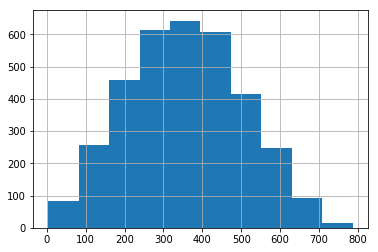

In [96]:
metadata.iloc[mismatches]["dist"].hist()

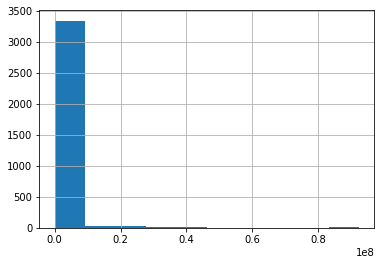

In [97]:
metadata.iloc[mismatches]["E"].hist()

In [288]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.utils import to_categorical

In [291]:
n_classes = 2
fpr = dict()
tpr=dict()
roc_auc=dict()
Y_true = to_categorical(y_true)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_true[:,i], Y_probs[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_true, y_pred)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

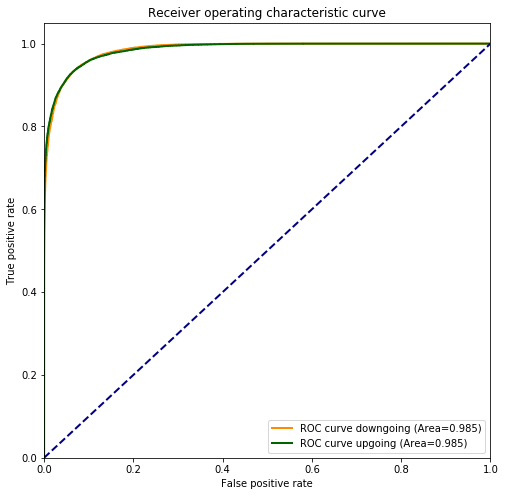

In [295]:
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr[0], tpr[0], color="darkorange",
         lw=lw, label="ROC curve downgoing (Area=%0.3f)" % roc_auc[0])
plt.plot(fpr[1], tpr[1], color="darkgreen",
         lw=lw, label="ROC curve upgoing (Area=%0.3f)" % roc_auc[1])

plt.plot([0,1],[0,1], color="navy", lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Receiver operating characteristic curve")
plt.legend(loc="lower right")
plt.show()


In [131]:
from sklearn.metrics import recall_score, precision_score, precision_recall_curve

In [136]:
from sklearn.metrics import average_precision_score

In [132]:
precision_score(y_true, y_pred)

0.9384609921522673

In [133]:
recall_score(y_true, y_pred)

0.9397624635516677

In [138]:
average_precision = average_precision_score(y_true, y_pred)

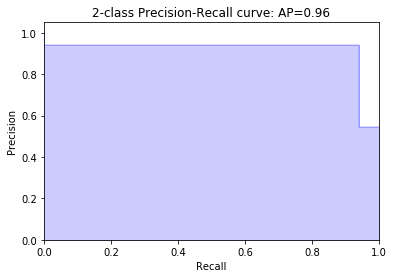

In [141]:
precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.step(recall, precision, color="b", alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.title("2-class Precision-Recall curve: AP={0:0.2f}".format(average_precision))

plt.show()

In [222]:
E_min = np.min(metadata["E"]) 
E_max = np.max(metadata["E"])
np.log10(E_min), np.log10(E_max)

(-1.266700796027743, 7.9684049553376921)

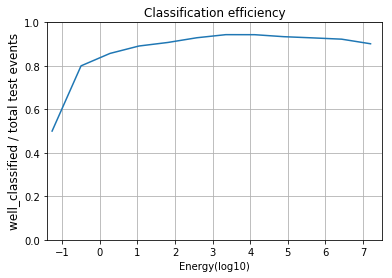

In [265]:
Energies = metadata["E"]

well_energies=metadata.iloc[y_true==y_pred]["E"]

binned_energies, energy_bins = np.histogram(np.log10(Energies), bins=12, range=(np.log10(E_min), np.log10(E_max)))

binned_well_cls, _ = np.histogram(np.log10(well_energies),  bins=12, range=(np.log10(E_min), np.log10(E_max)))

eff = np.true_divide(binned_well_cls, binned_energies)

plt.plot(energy_bins[:-1],eff)
plt.grid()
plt.xlabel("Energy(log10)")
plt.xlim([-1.4,7.5])
plt.ylim([0.0, 1.0])
plt.title("Classification efficiency")
plt.ylabel("well_classified / total test events", size=12)

In [232]:
metadata["dist"].min()

1.8131004306389762

In [237]:
dist_bins

array([   1.81310043,   71.04312532,  140.2731502 ,  209.50317508,
        278.73319997,  347.96322485,  417.19324974,  486.42327462,
        555.65329951,  624.88332439,  694.11334928,  763.34337416,
        832.57339905])

In [246]:
dist_bins[:-1].shape, eff.shape

((12,), (12,))

In [248]:
dist_bins

array([   1.81310043,   71.04312532,  140.2731502 ,  209.50317508,
        278.73319997,  347.96322485,  417.19324974,  486.42327462,
        555.65329951,  624.88332439,  694.11334928,  763.34337416,
        832.57339905])

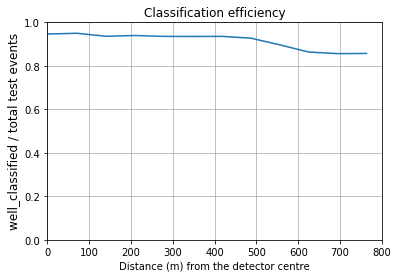

In [252]:
distances = metadata["dist"]
well_dist =metadata.iloc[y_true==y_pred]["dist"]

binned_distances, dist_bins = np.histogram(distances, bins=12, range=(distances.min(), distances.max()))
binned_well_cls, _ = np.histogram(well_dist,  bins=12, range=(distances.min(), distances.max()))

eff = np.true_divide(binned_well_cls, binned_distances)

plt.plot(dist_bins[:-1], eff)
plt.grid()
plt.xlabel("Distance (m) from the detector centre")
plt.xlim([-0.2,800])
plt.ylim([0.0, 1.0])
plt.title("Classification efficiency")
plt.ylabel("well_classified / total test events", size=12)